In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Reading in data
data = pd.read_csv("data_icu.csv")
#data = pd.read_csv("/Users/dylanmack/Library/CloudStorage/OneDrive-WashingtonUniversityinSt.Louis/ESE 527/surgical_critical_event_prediction/data_icu.csv")

In [2]:
# this contains data only on people who spent at least one day in the ICU
# icu_length = 0 means one day in the ICU, icu_length = 1 means two or more days in the ICU - RENAME as "inpatient"
data.head()

,caseid,subjectid,Age,Ht,Wt,Sex,OP_time,Open,Robotic,Videoscopic,icu_days,death_inhosp,age_group,icu_length,Mahalanobis
0,55,5077,18.0,175.1,59.2,0,292.55,1,0,0,3,0,child,1,2.082258
1,264,10,0.7,64.1,8.9,1,475.00,1,0,0,38,0,child,1,2.051887
2,280,5985,0.6,42.0,5.6,1,435.00,1,0,0,15,0,child,1,2.553821
3,366,10,0.8,64.1,8.9,1,115.00,1,0,0,38,0,child,1,1.676772
4,527,4603,18.0,185.0,62.6,0,210.00,1,0,0,1,0,child,0,1.775898


# Multiple Linear Regression

For this section, we will only consider people who did have ICU stays and will predict the number of days their stay lasted.

In [ ]:
# select the relevant variables
X_ml = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic']]
y_ml = data['icu_days']

# test/train split
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.2, random_state=10)

print(f'There are {len(y_train_ml)} training instances and {len(y_test_ml)} testing instances')

# train the model and make predictions
model_ml = LinearRegression()
model_ml.fit(X_train_ml, y_train_ml)
y_prediction_ml = model_ml.predict(X_test_ml)

plt.figure()
plt.hist(y_test_ml)

In [ ]:
# Coefficient of Determination (R²):
# R² explains the proportion of variance in the target variable that is explained by the predictors.
r2_ml = r2_score(y_test_ml, y_prediction_ml)
print(f'The feature variables explain {100*r2_ml}% of the variance in number of ICU days')

rmse_ml = mean_squared_error(y_test_ml, y_prediction_ml, squared = False)
print(f'The root mean squared error is {rmse_ml}')

# plotting residuals
residuals_ml = y_test_ml - y_prediction_ml
plt.scatter(y_prediction_ml, residuals_ml)
plt.hlines(0, min(y_prediction_ml), max(y_prediction_ml), colors="r", linestyles="dashed")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Logistic Regression (ICU)

Predict whether or not someone will have long or short ICU stay.

In [ ]:
X_lr_icu = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic']]
y_lr_icu = data['icu_length']

X_train_lr_icu, X_test_lr_icu, y_train_lr_icu, y_test_lr_icu = train_test_split(X_lr_icu, y_lr_icu, test_size=0.2, random_state=42)
print(f'There are {len(y_train_lr_icu)} training instances and {len(y_test_lr_icu)} testing instances')

# train the model and make predictions
model_lr_icu = LogisticRegression(class_weight="balanced", solver='liblinear', random_state=42)
model_lr_icu.fit(X_train_lr_icu, y_train_lr_icu)
y_prediction_lr_icu = model_lr_icu.predict(X_test_lr_icu)

In [ ]:
accuracy_icu = accuracy_score(y_test_lr_icu, y_prediction_lr_icu)
print("Accuracy:", accuracy_icu)

# Classification Report
print("Classification Report:\n", classification_report(y_test_lr_icu, y_prediction_lr_icu))

In [ ]:
# confusion matrix visualization

cm_icu = confusion_matrix(y_test_lr_icu, y_prediction_lr_icu)

plt.figure()
sns.heatmap(cm_icu, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Logistic Regression (Mortality)

In [ ]:
X_lr_mor = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic']]
y_lr_mor = data['death_inhosp']

X_train_lr_mor, X_test_lr_mor, y_train_lr_mor, y_test_lr_mor = train_test_split(X_lr_mor, y_lr_mor, test_size=0.2, random_state=42)
print(f'There are {len(y_train_lr_mor)} training instances and {len(y_test_lr_mor)} testing instances')

# train the model and make predictions
model_lr_mor = LogisticRegression(solver='liblinear', random_state=42)
model_lr_mor.fit(X_train_lr_mor, y_train_lr_mor)
y_prediction_lr_mor = model_lr_mor.predict(X_test_lr_mor)

In [ ]:
accuracy_mor = accuracy_score(y_test_lr_mor, y_prediction_lr_mor)
print("Accuracy:", accuracy_mor)

# Classification Report
print("Classification Report:\n", classification_report(y_test_lr_mor, y_prediction_lr_mor))
print("Confusion Matrix:\n", confusion_matrix(y_test_lr_mor, y_prediction_lr_mor))


cm_mor = confusion_matrix(y_test_lr_mor, y_prediction_lr_mor)
plt.figure()
sns.heatmap(cm_mor, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Again but weight towards minority class

model_lr_mor = LogisticRegression(class_weight="balanced", solver='liblinear', random_state=42)
model_lr_mor.fit(X_train_lr_mor, y_train_lr_mor)
y_prediction_lr_mor = model_lr_mor.predict(X_test_lr_mor)

accuracy_mor = accuracy_score(y_test_lr_mor, y_prediction_lr_mor)
print("Accuracy:", accuracy_mor)

# Classification Report
print("Classification Report:\n", classification_report(y_test_lr_mor, y_prediction_lr_mor))

cm_mor2 = confusion_matrix(y_test_lr_mor, y_prediction_lr_mor)
plt.figure()
sns.heatmap(cm_mor, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Random Forest (ICU)

In [ ]:
X_rf_icu = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic']]
y_rf_icu = data['icu_length']

X_train_rf_icu, X_test_rf_icu, y_train_rf_icu, y_test_rf_icu = train_test_split(X_rf_icu, y_rf_icu, test_size=0.2, random_state=42)
print(f'There are {len(y_train_rf_icu)} training instances and {len(y_test_rf_icu)} testing instances')

clf_icu = RandomForestClassifier(n_estimators=100, random_state=42)
clf_icu.fit(X_train_rf_icu, y_train_rf_icu)

y_pred_rf_icu = clf_icu.predict(X_test_rf_icu)



accuracy_rf_icu = accuracy_score(y_test_rf_icu, y_pred_rf_icu)
print("Accuracy:", accuracy_rf_icu)

# Classification Report
print("Classification Report:\n", classification_report(y_test_rf_icu, y_pred_rf_icu))

cm_rf_icu = confusion_matrix(y_test_rf_icu, y_pred_rf_icu)

plt.figure()
sns.heatmap(cm_rf_icu, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# XGBoost (ICU)

There are 913 training instances and 229 testing instances
Accuracy: 0.6943231441048034
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.82      0.77       146
           1       0.60      0.47      0.53        83

    accuracy                           0.69       229
   macro avg       0.67      0.65      0.65       229
weighted avg       0.68      0.69      0.68       229



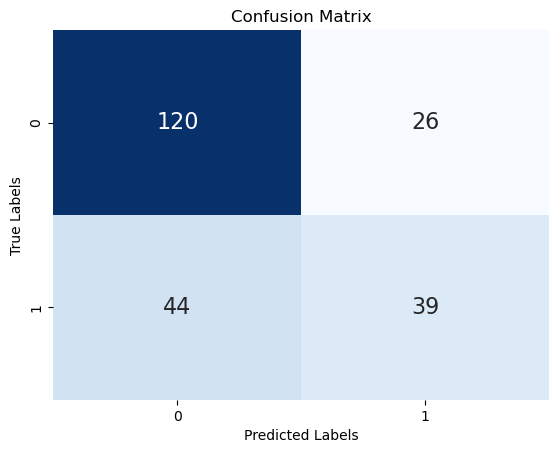

In [3]:
X_xgb_icu = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic']]
y_xgb_icu = data['icu_length']

X_train_xgb_icu, X_test_xgb_icu, y_train_xgb_icu, y_test_xgb_icu = train_test_split(X_xgb_icu, y_xgb_icu, test_size=0.2, random_state=42)
print(f'There are {len(y_train_xgb_icu)} training instances and {len(y_test_xgb_icu)} testing instances')

xgb_icu = xgb.XGBClassifier()
xgb_icu.fit(X_train_xgb_icu, y_train_xgb_icu)

y_pred_xgb_icu = xgb_icu.predict(X_test_xgb_icu)



accuracy_xgb_icu = accuracy_score(y_test_xgb_icu, y_pred_xgb_icu)
print("Accuracy:", accuracy_xgb_icu)

# Classification Report
print("Classification Report:\n", classification_report(y_test_xgb_icu, y_pred_xgb_icu))

cm_xgb_icu = confusion_matrix(y_test_xgb_icu, y_pred_xgb_icu)

plt.figure()
sns.heatmap(cm_xgb_icu, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# XGBoost Regression (Length of ICU Stay)

There are 913 training instances and 229 testing instances


(array([190.,  19.,  10.,   1.,   1.,   1.,   5.,   0.,   1.,   1.]),
 array([ 1. ,  3.5,  6. ,  8.5, 11. , 13.5, 16. , 18.5, 21. , 23.5, 26. ]),
 <BarContainer object of 10 artists>)

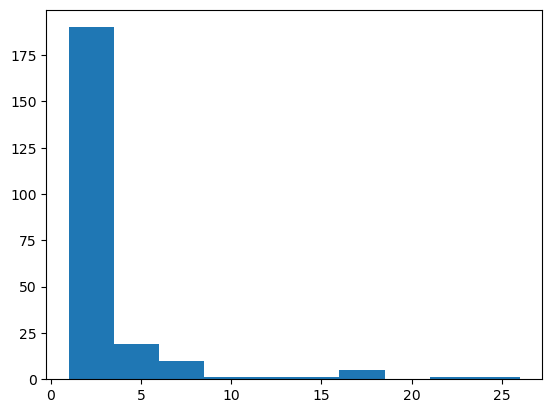

In [6]:
# select the relevant variables
X_xgb_licu = data[['Age', 'Ht', 'Wt', 'Sex', 'OP_time', 'Open', 'Robotic', 'Videoscopic']]
y_xgb_licu = data['icu_days']

# test/train split
X_train_xgb_licu, X_test_xgb_licu, y_train_xgb_licu, y_test_xgb_licu = train_test_split(X_xgb_licu, y_xgb_licu, test_size=0.2, random_state=10)

print(f'There are {len(y_train_xgb_licu)} training instances and {len(y_test_xgb_licu)} testing instances')

# train the model and make predictions
xgb_licu = xgb.XGBRegressor()
xgb_licu.fit(X_train_xgb_licu, y_train_xgb_licu)

y_pred_xgb_licu = xgb_licu.predict(X_test_xgb_licu)

plt.figure()
plt.hist(y_test_xgb_licu)

The feature variables explain -389.212094052777% of the variance in number of ICU days
The root mean squared error is 7.644859153090583


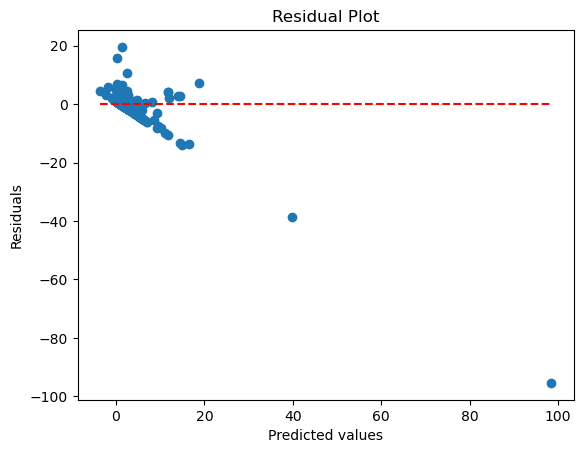

In [7]:
# Coefficient of Determination (R²):
# R² explains the proportion of variance in the target variable that is explained by the predictors.
r2_xgb_licu = r2_score(y_test_xgb_licu, y_pred_xgb_licu)
print(f'The feature variables explain {100*r2_xgb_licu}% of the variance in number of ICU days')

rmse_xgb_licu = mean_squared_error(y_test_xgb_licu, y_pred_xgb_licu, squared = False)
print(f'The root mean squared error is {rmse_xgb_licu}')

# plotting residuals
residuals_xgb_licu = y_test_xgb_licu - y_pred_xgb_licu
plt.scatter(y_pred_xgb_licu, residuals_xgb_licu)
plt.hlines(0, min(y_pred_xgb_licu), max(y_pred_xgb_licu), colors="r", linestyles="dashed")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()